### Imports

In [25]:
from httpx import AsyncClient
import aiosu
import asyncio
import os
import pandas as pd
import textwrap
import numpy as np

from dotenv import load_dotenv
load_dotenv()

True

## Defining random utilities

In [26]:
def flatten_seq(seq):
    """
    Flattens a list of lists into a single list
    """
    if isinstance(seq, list):
        for item in seq:
            yield from flatten_seq(item)
    else:
        yield seq


def get_api_page_offsets(total_items: int, max_page_size: int = 100):
    """
    Compute offsets for paginated API requests using the largest possible page size.

    Args:
        total_items (int): Total number of items available.
        max_page_size (int): Max items allowed per page (default=100).

    Returns:
        List[tuple]: List of (offset, limit) pairs for requests.
    """
    offsets = []
    for offset in range(0, total_items + 1, max_page_size):
        # limit is either max_page_size or what's remaining
        limit = min(max_page_size, total_items - offset)
        offsets.append(offset)
    return offsets

In [27]:
http_client = AsyncClient()

## Authenticating via OAuth

In [28]:
client = aiosu.v2.Client(
    client_id=os.environ['API_CLIENT_ID'],
    client_secret=os.environ['API_CLIENT_SECRET'],
    limiter=(240, 60)
)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000018DE4B55D90>


## Retrieving user profile

In [29]:
user_mode = aiosu.models.Gamemode.STANDARD
user_info = await client.get_user("Game4all", mode=user_mode)
print(user_info.model_dump_json(indent=True))

{
 "avatar_url": "https://a.ppy.sh/7559478?1659622115.jpeg",
 "country_code": "FR",
 "id": 7559478,
 "username": "Game4all",
 "default_group": "default",
 "is_active": true,
 "is_bot": false,
 "is_online": true,
 "is_supporter": false,
 "pm_friends_only": false,
 "profile_colour": null,
 "is_deleted": false,
 "last_visit": "2025-10-05T12:40:31Z",
 "discord": "Game4all#3489",
 "has_supported": true,
 "interests": "Being bad",
 "join_date": "2015-12-12T16:31:04Z",
 "kudosu": {
  "total": 0,
  "available": 0
 },
 "location": "behind your back",
 "max_blocks": 100,
 "max_friends": 500,
 "occupation": "School",
 "playmode": 0,
 "playstyle": [
  "keyboard",
  "tablet"
 ],
 "post_count": 0,
 "profile_hue": null,
 "profile_order": [
  "me",
  "recent_activity",
  "top_ranks",
  "medals",
  "historical",
  "beatmaps",
  "kudosu"
 ],
 "title": null,
 "twitter": null,
 "website": "https://bestwebsiteever",
 "country": {
  "code": "FR",
  "name": "France",
  "flag_emoji": "🇫🇷"
 },
 "cover": {
  "u

### Retrieving user scores (best + recent) 

In [30]:
# Gather all the historical user scores
top_score_offsets = get_api_page_offsets(user_info.scores_best_count, 100)
top_scores = await asyncio.gather(*[client.get_user_bests(user_info.id, limit=100, offset=o, new_format=True, mode=user_mode) for o in top_score_offsets])
top_scores = list(flatten_seq(top_scores))

# Gather all the user recent scores
recent_score_offsets = get_api_page_offsets(user_info.scores_recent_count, 100)
recent_scores = await asyncio.gather(*[client.get_user_recents(user_info.id, limit=100, offset=o, new_format=True, mode=user_mode) for o in recent_score_offsets])
recent_scores = list(flatten_seq(recent_scores))

scores = recent_scores + top_scores

len(scores)

207

## Preprocessing scores

In [31]:
print(scores[0].model_dump_json(indent=True))

{
 "accuracy": 0.878626,
 "beatmap_id": 3299160,
 "ended_at": "2025-10-05T10:37:19Z",
 "has_replay": false,
 "is_perfect_combo": false,
 "legacy_perfect": false,
 "max_combo": 368,
 "maximum_statistics": {
  "miss": 0,
  "meh": 0,
  "ok": 0,
  "good": 0,
  "great": 563,
  "perfect": 0,
  "small_tick_miss": 0,
  "small_tick_hit": 0,
  "large_tick_miss": 0,
  "large_tick_hit": 0,
  "small_bonus": 0,
  "large_bonus": 0,
  "ignore_miss": 0,
  "ignore_hit": 0,
  "combo_break": 0,
  "slider_tail_hit": 0,
  "legacy_combo_increase": 254
 },
 "mods": [
  {
   "acronym": "CL",
   "settings": {}
  }
 ],
 "passed": true,
 "rank": "B",
 "ruleset_id": 0,
 "statistics": {
  "miss": 14,
  "meh": 10,
  "ok": 69,
  "good": 0,
  "great": 470,
  "perfect": 0,
  "small_tick_miss": 0,
  "small_tick_hit": 0,
  "large_tick_miss": 0,
  "large_tick_hit": 0,
  "small_bonus": 0,
  "large_bonus": 0,
  "ignore_miss": 0,
  "ignore_hit": 0,
  "combo_break": 0,
  "slider_tail_hit": 0,
  "legacy_combo_increase": 0
 },


In [32]:
def normalize_rank(rank: str) -> str:
    """
    Normalize silver ranks to standard ranks.
    """
    if rank in ['XH', 'X']:
        return 'X'
    elif rank in ['SH', 'S']:
        return 'S'
    elif rank in ['A', 'B', 'C', 'D', 'F']:
        return rank
    else:
        return 'UNK'


def rank_to_label(rank: str) -> int:
    """
    Convert rank string to numerical label.
    """
    rank_mapping = {'X': 5, 'S': 4, 'A': 3, 'B': 2, 'C': 1, 'D': 0, 'F': -1}
    return rank_mapping.get(rank, -2)  # Return -2 for unknown ranks


def normalize_mods(mods: str) -> list[str]:
    """
    Normalize mods string to a list of mod abbreviations and remove classic mod ('CL') and normalizes mods that are supersets of others.
    """
    mods_split = [x for x in textwrap.wrap(mods, 2) if x != 'CL']
    # Replace NC by DT and PF by SD if present in the mods
    mods_split = ['DT' if x == 'NC' else 'SD' if x ==
                  'PF' else x for x in mods_split]
    return mods_split


def preprocess_scores_dataset(scores: list[aiosu.models.LazerScore]) -> pd.DataFrame:
    """
    Preprocess a list of Score objects into a DataFrame with relevant features for model training.
    """
    df = pd.DataFrame()

    # all ID fields
    df['score_id'] = [score.id for score in scores]
    df['beatmap_id'] = [score.beatmap_id for score in scores]
    df['ruleset_id'] = [score.ruleset_id for score in scores]

    # basic score info (= prediction targets)
    df['accuracy'] = [score.accuracy for score in scores]
    df['miss_count'] = [score.statistics.miss for score in scores]
    df['mods'] = [normalize_mods(score.mods_str) for score in scores]

    # beatmap object counts
    df['count_objects'] = [score.beatmap.count_objects for score in scores]
    df['count_circles'] = [score.beatmap.count_circles for score in scores]
    df['count_sliders'] = [score.beatmap.count_sliders for score in scores]
    df['count_spinners'] = [score.beatmap.count_spinners for score in scores]

    # base beatmap attributes
    df['star_rating'] = [score.beatmap.difficulty_rating for score in scores]
    df['length'] = [score.beatmap.hit_length for score in scores]
    df['bpm'] = [score.beatmap.bpm for score in scores]
    df['od'] = [score.beatmap.accuracy for score in scores]
    df['ar'] = [score.beatmap.ar for score in scores]
    df['cs'] = [score.beatmap.cs for score in scores]
    df['hp'] = [score.beatmap.drain for score in scores]

    return df


async def prepare_predicted_dataset(map_ids: list[tuple[int, str]]) -> pd.DataFrame:
    """
    Fetch beatmap information for given map IDs and creates a DataFrame of preprocessed features for prediction.
    """
    map_info = await asyncio.gather(*[client.get_beatmap(bid) for (bid, mods) in map_ids], return_exceptions=False)
    df = pd.DataFrame()

    # all ID fields
    df['beatmap_id'] = [beatmap.id for beatmap in map_info]

    # mods info
    df['mods'] = [normalize_mods(mods) for (_, mods) in map_ids]

    # base beatmap attributes
    df['count_objects'] = [beatmap.count_objects for beatmap in map_info]
    df['count_circles'] = [beatmap.count_circles for beatmap in map_info]
    df['count_sliders'] = [beatmap.count_sliders for beatmap in map_info]
    df['count_spinners'] = [beatmap.count_spinners for beatmap in map_info]
    df['total_objects'] = df['count_objects'] # create a duplicate of count objects for predicting hit distrib

    # base beatmap attributes
    df['star_rating'] = [beatmap.difficulty_rating for beatmap in map_info]
    df['length'] = [beatmap.hit_length for beatmap in map_info]
    df['bpm'] = [beatmap.bpm for beatmap in map_info]
    df['od'] = [beatmap.accuracy for beatmap in map_info]
    df['ar'] = [beatmap.ar for beatmap in map_info]
    df['cs'] = [beatmap.cs for beatmap in map_info]
    df['hp'] = [beatmap.drain for beatmap in map_info]

    return df


async def preprocess_beatmap_attributes(scores: pd.DataFrame, client: aiosu.v2.Client, user_mode: aiosu.models.Gamemode) -> pd.DataFrame:
    """
    Fetch and append beatmap attributes to the DataFrame.
    """
    df = pd.DataFrame()

    map_attributes = await asyncio.gather(*[client.get_beatmap_attributes(bid, mode=user_mode) for bid in scores['beatmap_id']], return_exceptions=False)

    # base beatmap difficulty attributes (without mods applied)
    df['beatmap_id'] = [id for id in scores['beatmap_id']]
    df['aim_stars'] = [attr.aim_difficulty for attr in map_attributes]
    df['speed_stars'] = [attr.speed_difficulty for attr in map_attributes]
    df['flashlight_stars'] = [attr.flashlight_difficulty for attr in map_attributes]
    df['approach_rate'] = [attr.approach_rate for attr in map_attributes]
    df['slider_factor'] = [attr.slider_factor for attr in map_attributes]
    df['speed_note_count'] = [attr.speed_note_count for attr in map_attributes]
    df['aim_difficult_strain_count'] = [
        attr.aim_difficult_strain_count for attr in map_attributes]
    df['speed_difficult_strain_count'] = [
        attr.speed_difficult_strain_count for attr in map_attributes]
    df['stamina_difficulty'] = [
        attr.stamina_difficulty for attr in map_attributes]
    df['rhythm_difficulty'] = [attr.rhythm_difficulty for attr in map_attributes]

    return df


scores_df = preprocess_scores_dataset(scores)
map_attr_df = await preprocess_beatmap_attributes(scores_df, client, user_mode)

score_data_df = pd.merge(scores_df, map_attr_df, on='beatmap_id')

In [33]:
score_data_df = score_data_df.fillna(0)
# full_df.drop_duplicates(subset=['score_id'], inplace=True)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_7928\4251396292.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  score_data_df = score_data_df.fillna(0)


## Labeling, normalization and scaling of values

In [34]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


def prepare_features(full_df: pd.DataFrame, ranked_mods: list[str], scaler: Optional[MinMaxScaler] = None) -> tuple[pd.DataFrame, MinMaxScaler]:
    """
    Prepares the features and labels for model training by applying necessary scaling and encoding.

    Args:
        full_df (pd.DataFrame): The full DataFrame with all features.
        ranked_mods (list[str]): List of ranked mods for the ruleset to one-hot encode. 

    Returns:
        Returns the prepared features DataFrame and the fitted scaler.
    """
    # Fields to log scale before normalization
    LOG_SCALED_FIELDS = ['length', 'count_objects', 'count_circles', 'count_sliders', 'count_spinners',
                         'speed_note_count', 'aim_difficult_strain_count', 'speed_difficult_strain_count']

    # Fields to normalize
    NORMALIZED_FIELDS = ['star_rating', 'bpm', 'od', 'ar', 'cs', 'hp', 'aim_stars', 'speed_stars',
                         'flashlight_stars', 'approach_rate', 'stamina_difficulty', 'rhythm_difficulty'] + LOG_SCALED_FIELDS

    c_df = full_df.copy()

    is_fit = scaler is not None
    feature_scaler = MinMaxScaler() if not scaler else scaler

    # log scale relevant fields
    for field in LOG_SCALED_FIELDS:
        c_df[field] = np.log1p(c_df[field])

    # normalize relevant fields
    c_df[NORMALIZED_FIELDS] = feature_scaler.fit_transform(
        c_df[NORMALIZED_FIELDS]) if not is_fit else feature_scaler.transform(c_df[NORMALIZED_FIELDS])

    # One-hot encode mods into separate columns
    for mod in ranked_mods:
        c_df[f'mod_{mod}'] = c_df['mods'].apply(
            lambda mods: 1 if str(mod) in mods else 0)

    if not is_fit:
        return c_df, feature_scaler
    else:
        return c_df


# list of all ranked mods without their supersets (for standard mode)
ALL_RANKED_MODS = [
    aiosu.models.mods.Mod.NoFail,
    aiosu.models.mods.Mod.Easy,
    aiosu.models.mods.Mod.TouchDevice,
    aiosu.models.mods.Mod.Hidden,
    aiosu.models.mods.Mod.HardRock,
    aiosu.models.mods.Mod.SuddenDeath,
    aiosu.models.mods.Mod.DoubleTime,
    aiosu.models.mods.Mod.HalfTime,
    aiosu.models.mods.Mod.Flashlight,
    aiosu.models.mods.Mod.SpunOut,
]

scaled_features_df, fitted_scaler = prepare_features(
    score_data_df, ALL_RANKED_MODS)

In [35]:
X_df = scaled_features_df.drop(
    columns=['score_id', 'beatmap_id', 'ruleset_id', 'accuracy', 'mods', 'miss_count'])
Y_df = scaled_features_df[['accuracy', 'miss_count']]

In [36]:
from sklearn.model_selection import KFold

# initialize kfold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=69420)

## Training the model(s)

#### Accuracy predictor using bayesian regression

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

acc_scores = []

#  Train a linear regression model to predict accuracy based on the features
acc_predictor = BayesianRidge(max_iter=500)
for train_index, test_index in kfold.split(X_df):
    train_X, test_X = X_df.iloc[train_index], X_df.iloc[test_index]
    train_Y, test_Y = Y_df.iloc[train_index], Y_df.iloc[test_index]

    acc_predictor.fit(train_X, train_Y['accuracy'])

    y_acc_pred = acc_predictor.predict(test_X)
    acc_scores.append(mean_squared_error(test_Y['accuracy'], y_acc_pred))

mean_mse = np.mean(acc_scores)

print(f"Test MSE: {mean_mse}")

Test MSE: 0.00014430232110024377


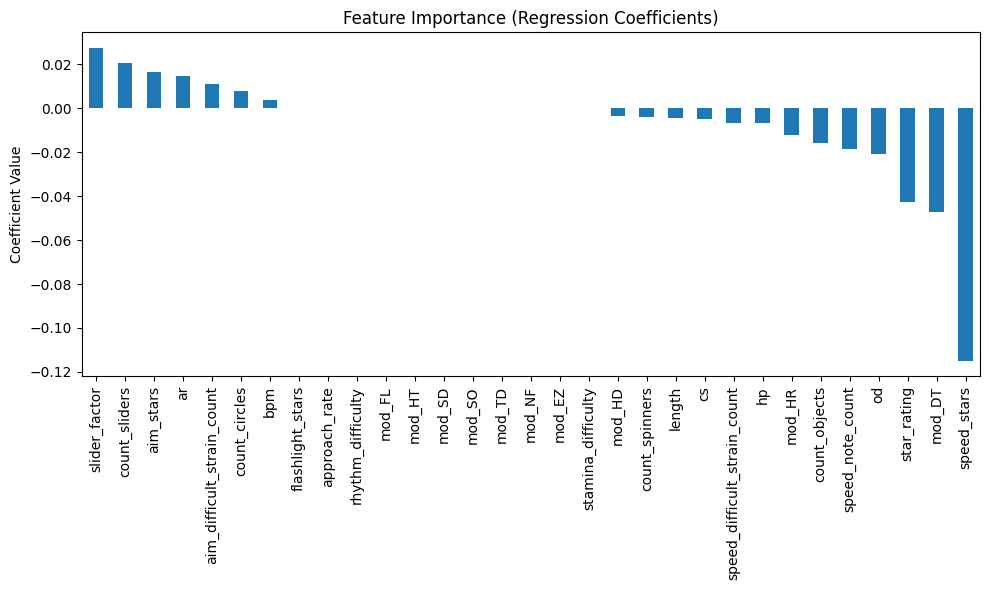

In [38]:
# Plot feature importance
import matplotlib.pyplot as plt

feature_importance = pd.Series(acc_predictor.coef_, index=train_X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [39]:
Y_df

,accuracy,miss_count
0,0.878626,14
1,0.925556,4
2,0.973997,3
3,0.988245,2
4,0.988245,2
...,...,...
210,0.990893,0
211,0.986551,4
212,0.982835,1
213,0.967638,0


## Final prediction function

In [40]:
from scipy.stats import norm

def discrete_quantiles_from_probs(probs, qs=(0.05, 0.5, 0.95)):
    """
    Compute discrete quantiles from class probabilities
    """
    p = np.asarray(probs)
    single = (p.ndim == 1)
    if single:
        p = p[None, :]  # make 2D

    n, K = p.shape
    ks = np.arange(K)

    # normalize row-wise (avoid division errors)
    row_sums = p.sum(axis=1, keepdims=True)
    zero_mask = (row_sums.squeeze() == 0)
    if zero_mask.any():
        p[zero_mask] = 1.0 / K
        row_sums = p.sum(axis=1, keepdims=True)
    p = p / row_sums

    cdf = np.cumsum(p, axis=1)  # cumulative along classes
    quantiles = np.empty((n, len(qs)), dtype=int)

    for j, q in enumerate(qs):
        if not (0 < q < 1):
            raise ValueError("qs must be between 0 and 1 (exclusive)")
        hits = (cdf >= q)
        idx = hits.argmax(axis=1)
        no_hit = (cdf[:, -1] < q)  # if rounding caused no hit
        idx[no_hit] = K - 1
        quantiles[:, j] = ks[idx]

    return quantiles[0] if single else quantiles


def sample_norm_distrib(mu: float, std: float, percentile: float) -> float:
    """Samples a normal distribution with the given parameters at the given percentile"""
    return norm.ppf(percentile, loc=mu, scale=std)


def calc_standard_hits(accuracy: float, total_objects: int, n_misses: int) -> tuple[int, int, int, int]:
    """
    Calculate number of 300s, 100s and 50s of a standard score.

    Args:
    - acc: accuracy as a decimal (e.g., 0.975 for 97.5%)
    - total_objects: total number of hit objects (including misses)
    - misses: number of misses

    Assumes no 50s.
    """

    n300 = (300 * accuracy * total_objects - 100 *
            total_objects + 100 * n_misses) / 200
    n100 = total_objects - n_misses - n300

    return int(round(n300)), int(round(n100)), int(0), int(n_misses)

def calc_standard_hits_vec(accuracy: np.ndarray, total_objects: np.ndarray, n_misses: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vectorized calculation of 300s, 100s, 50s, and misses for multiple samples.

    Args:
    - accuracy: np.ndarray of shape (n_samples,)
    - total_objects: np.ndarray of shape (n_samples,)
    - n_misses: np.ndarray of shape (n_samples,)

    Returns:
    - n300, n100, n50, nmiss as np.ndarrays of shape (n_samples,)
    """
    n300 = (300 * accuracy * total_objects - 100 * total_objects + 100 * n_misses) / 200
    n100 = total_objects - n_misses - n300
    n50 = np.zeros_like(n300)
    n300 = np.round(n300).astype(int)
    n100 = np.round(n100).astype(int)
    nmiss = n_misses.astype(int)
    
    return n300, n100, n50, nmiss


def calc_standard_grade(n_300: int, n_100: int, n_50: int, n_miss: int, total_objects: int) -> str:
    """
    Compute osu! standard grade based on hit distribution.

    Args:
            n_300: Number of 300s
            n_100: Number of 100s
            n_50: Number of 50s
            n_miss: Number of misses
            total_objects: Total number of hit objects

    Returns:
            str: Grade (SS, S, A, B, C, D)
    """
    if total_objects == 0:
        return "D"

    acc = (n_300 * 300 + n_100 * 100 + n_50 * 50) / (total_objects * 300)
    pct_300 = n_300 / total_objects
    pct_50 = n_50 / total_objects

    if acc == 1.0:
        return "X"
    elif pct_300 > 0.9 and pct_50 <= 0.01 and n_miss == 0:
        return "S"
    elif (pct_300 > 0.8 and n_miss == 0) or (pct_300 > 0.9):
        return "A"
    elif (pct_300 > 0.7 and n_miss == 0) or (pct_300 > 0.8):
        return "B"
    elif pct_300 > 0.6:
        return "C"
    else:
        return "D"
    
def calc_standard_grade_vec(n_300: np.ndarray, n_100: np.ndarray, n_50: np.ndarray, n_miss: np.ndarray, total_objects: np.ndarray) -> np.ndarray:
    """
    Vectorized computation of osu! standard grades for multiple samples.

    Args:
        n_300, n_100, n_50, n_miss, total_objects: np.ndarrays of shape (n_samples,)

    Returns:
        np.ndarray of str grades (shape: n_samples)
    """
    grades = np.full_like(n_300, "D", dtype=object)  # default grade is D

    # avoid division by zero
    total_objects_safe = np.where(total_objects == 0, 1, total_objects)

    acc = (n_300 * 300 + n_100 * 100 + n_50 * 50) / (total_objects_safe * 300)
    pct_300 = n_300 / total_objects_safe
    pct_50 = n_50 / total_objects_safe

    # X grade (perfect accuracy)
    grades[acc == 1.0] = "X"

    # S grade
    mask_s = (pct_300 > 0.9) & (pct_50 <= 0.01) & (n_miss == 0) & (grades != "X")
    grades[mask_s] = "S"

    # A grade
    mask_a = ((pct_300 > 0.8) & (n_miss == 0) | (pct_300 > 0.9)) & (~mask_s) & (grades != "X")
    grades[mask_a] = "A"

    # B grade
    mask_b = ((pct_300 > 0.7) & (n_miss == 0) | (pct_300 > 0.8)) & (~mask_s) & (~mask_a) & (grades != "X")
    grades[mask_b] = "B"

    # C grade
    mask_c = (pct_300 > 0.6) & (~mask_s) & (~mask_a) & (~mask_b) & (grades != "X")
    grades[mask_c] = "C"

    # D is already default, no need to mask

    return grades

In [41]:
from pandas import DataFrame
from sklearn.linear_model import BayesianRidge


def predict_performance(full_df: DataFrame, acc_model: BayesianRidge) -> DataFrame:
    """
    Predict accuracy and miss count for the given DataFrame of beatmaps.

    Args:
        full_df (DataFrame): DataFrame containing beatmap features, already preprocessed and scaled.
        acc_model (LogisticRegression): Trained accuracy prediction model.
        miss_count_model (GradientBoostingClassifier): Trained miss count prediction model.

    Returns:
        DataFrame: DataFrame with predicted accuracy and miss count.
    """
    X_pred = full_df.drop(
        columns=['beatmap_id', 'mods', 'total_objects'])
    result_df = full_df[['beatmap_id', 'mods']].copy()

    # compute an out of distribution factor for each map to predict (basically how many attributes are out of distribution)
    ood_factors = (X_pred > 1).sum(
        axis=1) / len(X_pred.columns)
    ood_discount_factor = np.array(1.0 - ood_factors)
    result_df['ood_discount_factor'] = ood_discount_factor

    # get predicted accuracy mean and std deviation
    pred_mean_acc, pred_acc_std = acc_model.predict(X_pred, return_std=True)
    pred_mean_acc, pred_acc_std = np.array(
        pred_mean_acc), np.array(pred_acc_std)

    # ========================= accuracy computations ============================

    # define quantiles
    case_quantiles = np.array([0.25, 0.5, 0.95])

    # compute z score for each quantile
    z_scores = np.array([sample_norm_distrib(0, 1, q)
                        for q in case_quantiles])  # shape (3,)
    # shape (n_samples, 3)
    pred_acc_quantiles = ((
        pred_mean_acc[:, None] + pred_acc_std[:, None] * z_scores).clip(0, 1)) * ood_discount_factor[:, np.newaxis]

    # store predicted accuracies in result_df
    result_df[['worst_case_accuracy', 'average_case_accuracy',
               'best_case_accuracy']] = pred_acc_quantiles

    # =============================================================================

    # save total object number for later
    result_df['total_objects'] = full_df['total_objects']

    for i, case in enumerate(['worst', 'average', 'best']):
        n300, n100, n50, nmiss = calc_standard_hits_vec(
            pred_acc_quantiles[:, i], result_df['total_objects'].values, np.full(pred_acc_quantiles[:, i].shape, 0))
        result_df[f'{case}_case_grade'] = calc_standard_grade_vec(
            n300, n100, n50, nmiss, result_df['total_objects'].values)

    return result_df

# Attempting to predict user performance on maps

In [42]:
test_maps = [
    (4921731, "HDDT"),
    (4921665, "HD"),
    (4921665, "HR"),
    (1114721, ""),
    (1114721, "HDHR")
]

test_maps_df = await prepare_predicted_dataset(test_maps)
test_map_features_df = await preprocess_beatmap_attributes(test_maps_df, client, user_mode=user_mode)

test_full_df = pd.merge(test_maps_df, test_map_features_df, on='beatmap_id')
test_full_df.fillna(0, inplace=True)

prepared_test_df = prepare_features(
    test_full_df, ALL_RANKED_MODS, scaler=fitted_scaler)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_7928\3393197616.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_full_df.fillna(0, inplace=True)


In [43]:
prepared_test_df

,beatmap_id,mods,count_objects,count_circles,count_sliders,count_spinners,total_objects,star_rating,length,bpm,...,mod_NF,mod_EZ,mod_TD,mod_HD,mod_HR,mod_SD,mod_DT,mod_HT,mod_FL,mod_SO
0,4921731,"[HD, DT]",0.507795,0.194024,0.781528,0.0,263,0.232836,0.485805,0.791045,...,0,0,0,1,0,0,1,0,0,0
1,4921665,[HD],0.546389,0.376411,0.744387,0.0,283,0.758209,0.485805,0.791045,...,0,0,0,1,0,0,0,0,0,0
2,4921665,[HD],0.546389,0.376411,0.744387,0.0,283,0.758209,0.485805,0.791045,...,0,0,0,1,0,0,0,0,0,0
3,4921665,[HR],0.546389,0.376411,0.744387,0.0,283,0.758209,0.485805,0.791045,...,0,0,0,0,1,0,0,0,0,0
4,4921665,[HR],0.546389,0.376411,0.744387,0.0,283,0.758209,0.485805,0.791045,...,0,0,0,0,1,0,0,0,0,0
5,1114721,[],1.373767,1.160941,1.254839,0.0,1358,1.080597,1.195383,0.492537,...,0,0,0,0,0,0,0,0,0,0
6,1114721,[],1.373767,1.160941,1.254839,0.0,1358,1.080597,1.195383,0.492537,...,0,0,0,0,0,0,0,0,0,0
7,1114721,"[HD, HR]",1.373767,1.160941,1.254839,0.0,1358,1.080597,1.195383,0.492537,...,0,0,0,1,1,0,0,0,0,0
8,1114721,"[HD, HR]",1.373767,1.160941,1.254839,0.0,1358,1.080597,1.195383,0.492537,...,0,0,0,1,1,0,0,0,0,0


In [44]:
predict_performance(prepared_test_df, acc_predictor)

,beatmap_id,mods,ood_discount_factor,worst_case_accuracy,average_case_accuracy,best_case_accuracy,total_objects,worst_case_grade,average_case_grade,best_case_grade
0,4921731,"[HD, DT]",1.000000,0.959321,0.985840,1.000000,263,S,S,X
1,4921665,[HD],1.000000,0.960009,0.986549,1.000000,283,S,S,X
2,4921665,[HD],1.000000,0.960009,0.986549,1.000000,283,S,S,X
3,4921665,[HR],1.000000,0.951182,0.978062,1.000000,283,S,S,X
4,4921665,[HR],1.000000,0.951182,0.978062,1.000000,283,S,S,X
5,1114721,[],0.806452,0.737546,0.758996,0.806452,1358,C,C,B
6,1114721,[],0.806452,0.737546,0.758996,0.806452,1358,C,C,B
7,1114721,"[HD, HR]",0.806452,0.723913,0.746365,0.801119,1358,D,C,B
8,1114721,"[HD, HR]",0.806452,0.723913,0.746365,0.801119,1358,D,C,B


# Predict user performance on recommended maps

In [45]:
stat_avgs = score_data_df.agg({
    "star_rating": ['mean', 'std'],
    "ar": ['mean', 'std'],
    "od": ['mean', 'std'],
    "cs": ['mean', 'std']
})

display(stat_avgs)

# stars_mean = score_data_df['star_rating'].mean()
# stars_dev = score_data_df['star_rating'].std()

# # Get min star rating and max star rating
# stars_min = stars_mean - stars_dev
# stars_max = stars_mean + stars_dev

# round(stars_min, 1), round(stars_max, 1), round(ar_mean, 1)

,star_rating,ar,od,cs
mean,4.761302,8.914419,8.032558,3.815814
std,0.685553,0.334366,0.629390,0.282233


In [46]:
KITSU_BASE_URL = "https://osu.direct/api/v2/"

In [47]:
recommendations = await http_client.get('https://osu.direct/api/v2/recommend', params={
    "amount": 5,
    "minStars": stat_avgs['star_rating']['mean'] - stat_avgs['star_rating']['std'],
    "maxStars": stat_avgs['star_rating']['mean'] + stat_avgs['star_rating']['std'],
    'mode': 0,
    'status': 1
})

recommendations.json()

[{'id': 4254373,
  'beatmapset_id': 2039561,
  'difficulty_rating': 4.89,
  'mode': 'osu',
  'status': 'ranked',
  'total_length': 201,
  'user_id': 700887,
  'version': 'BAU BAU >w<',
  'accuracy': 8,
  'ar': 9,
  'bpm': 170,
  'convert': False,
  'count_circles': 421,
  'count_sliders': 328,
  'count_spinners': 0,
  'cs': 4,
  'deleted_at': None,
  'drain': 6,
  'hit_length': 189,
  'is_scoreable': True,
  'last_updated': '2025-04-19T01:55:53Z',
  'mode_int': 0,
  'passcount': 3284,
  'playcount': 19324,
  'ranked': 1,
  'url': 'https://osu.ppy.sh/beatmaps/4254373',
  'checksum': '92cd76398d6d2d56b46810fdfc8e3c6a',
  'max_combo': 1080},
 {'id': 2448572,
  'beatmapset_id': 1172523,
  'difficulty_rating': 4.38,
  'mode': 'osu',
  'status': 'ranked',
  'total_length': 238,
  'user_id': 5226970,
  'version': 'Insane',
  'accuracy': 8,
  'ar': 9,
  'bpm': 190,
  'convert': False,
  'count_circles': 216,
  'count_sliders': 447,
  'count_spinners': 1,
  'cs': 4,
  'deleted_at': None,
  'dra

In [48]:
prepared_test_df.groupby('mods')